In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import imp

sn.set_context('notebook')

# Import model
nope_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
             r'\Python\rid\notebooks\nope.py')
nope = imp.load_source('nope', nope_path)

# Estimating loads in unmonitored regions

The output from the new model can be used to estimate loads in unmonitored areas. We know the regine ID for each of the 155 stations where water chemistry is measured, and we also know which OSPAR region each monitoring site drains to. We want to use observed data to estimate loads upstream of each monitoring point, and modelled data elsewhere. This can easily be achieved using the output from the new model.

**Note:** In the code below, I'm assuming that we want to use the observed data for all 155 sites. In reality, values for the `RID_108` stations are estimated using linear interpolation, so we may prefer to use the modelled output for these anyway. Furthermore, in the OSPAR template we only report observed values for the 11 main rivers. The choice of which sites to consider "observed" can easily be controlled by reading different sheet(s) into `stn_df` in the code below.

## 1. Total N and P

### 1.1. Identify areas with monitoring data

Where observations are available, we want to use them in preference to the model output. This means identifying all the catchments with observed data and substracting the model results for these locations. This is more complicated than it appears, because a small number of observed catchments are upstream of others, so subtracting all the loads for the 155 monitored catchments involves "double accounting", which we want to avoid. The first step is therefore to identify the downstream-most nodes for the monitored areas i.e. for the cases where one catchment is upstream of another, we just want the downstream node.

In [2]:
# Read station data
in_xlsx = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\Data\RID_Sites_List.xlsx')
stn_df = pd.read_excel(in_xlsx, sheetname='RID_All')

# Get just cols of interest and drop duplicates 
# (some sites are in the same regine)
stn_df = stn_df[['ospar_region', 'nve_vassdrag_nr']].drop_duplicates()

# Get catch IDs with calib data
calib_nds = set(stn_df['nve_vassdrag_nr'].values)

# Build network
in_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\NOPE_Annual_Inputs\nope_input_data_1990.csv')
g, nd_list = nope.build_calib_network(in_path, calib_nds)

# Get list of downstream nodes
ds_nds = []
for nd in g:
    # If no downstream nodes
    if g.out_degree(nd) == 0:
        # Node is of interest
        ds_nds.append(nd)

# Get just the downstream catchments
stn_df = stn_df[stn_df['nve_vassdrag_nr'].isin(ds_nds)]

### 1.2. Sum model results for monitored locations

In [3]:
# Read model output
in_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
          r'\NOPE\nope_results_2015.csv')
nope_df = pd.read_csv(in_csv)

# Join accumulated outputs to stns of interest
mon_df = pd.merge(stn_df, nope_df, how='left',
                  left_on='nve_vassdrag_nr',
                  right_on='regine')

# Groupby OSPAR region
mon_df = mon_df.groupby('ospar_region').sum()

# Get just accum cols
cols = [i for i in mon_df.columns if i.split('_')[0]=='accum']
mon_df = mon_df[cols]

mon_df.head()

,accum_all_point_tot-n_tonnes,accum_all_point_tot-p_tonnes,accum_all_sources_tot-n_tonnes,accum_all_sources_tot-p_tonnes,accum_anth_diff_tot-n_tonnes,accum_anth_diff_tot-p_tonnes,accum_aqu_tot-n_tonnes,accum_aqu_tot-p_tonnes,accum_ind_tot-n_tonnes,accum_ind_tot-p_tonnes,accum_nat_diff_tot-n_tonnes,accum_nat_diff_tot-p_tonnes,accum_q_m3/s,accum_ren_tot-n_tonnes,accum_ren_tot-p_tonnes,accum_spr_tot-n_tonnes,accum_spr_tot-p_tonnes,accum_upstr_area_km2
ospar_region,,,,,,,,,,,,,,,,,,
LOFOTEN-BARENTS SEA,86.653008,6.074953,4368.664495,63.624939,139.942219,5.257379,0.0,0.0,0.000000,0.000000,4142.069267,52.292606,894.898861,33.467862,1.197379,50.645592,4.659198,63555.61
NORTH SEA,390.328784,36.280314,15494.218660,211.197354,2573.737601,67.956573,0.0,0.0,10.364882,0.208263,12530.152275,106.960467,2062.883890,214.917480,23.786032,130.184271,10.109550,23353.19
NORWEGIAN SEA2,546.106244,40.984800,13788.740679,260.203375,2688.678894,73.340960,0.0,0.0,10.296000,1.352000,10553.955540,145.877614,2030.716618,307.243356,18.370216,187.803070,18.201039,45896.63
SKAGERAK,3628.409215,85.017503,32875.851606,477.088393,11030.017027,238.423779,0.0,0.0,47.510520,2.170000,18217.425365,153.647111,2560.851657,2618.714213,25.268029,860.104855,52.032651,93945.27


This table gives the **modelled** inputs to each OSPAR region from catchments for which we have observed data. We want to subtract these values from the overall modelled inputs to each region and substitute the observed data instead.

The trickiest part of this is that the OSPAR regions in the TEOTIL catchment network (and therefore the network for my new model too) don't exactly match the new OSPAR definitions. The OSPAR boundaries were updated relatively recently, so instead of simply selecting the desired OSPAR region in the model output, I need to aggregate based on vassdragsnummers.

**Note:** Eventually, it would be a good idea to update the network information in `regine.csv` to reflect the current OSPAR regions.

### 1.3. Group model output according to "new" OSPAR regions

In [4]:
# Define "new" OSPAR regions
os_dict = {'SKAGERAK':(1, 23),
           'NORTH SEA':(24, 90),
           'NORWEGIAN SEA2':(91, 170),
           'LOFOTEN-BARENTS SEA':(171, 247)}

# Container for results
df_list = []

# Loop over model output
for reg in os_dict.keys():
    min_id, max_id = os_dict[reg]
    
    regs = ['%03d.' % i for i in range(min_id, max_id+1)]
    
    # Get data for this region
    df2 = nope_df[nope_df['regine'].isin(regs)]
    
    # Get just accum cols
    cols = [i for i in df2.columns if i.split('_')[0]=='accum']
    df2 = df2[cols]
    
    # Add region
    df2['ospar_region'] = reg
    
    # Add sum to output
    df_list.append(df2)

# Build df
os_df = pd.concat(df_list, axis=0)

# Aggregate
os_df = os_df.groupby('ospar_region').sum()

os_df.head()

,accum_all_point_tot-n_tonnes,accum_all_point_tot-p_tonnes,accum_all_sources_tot-n_tonnes,accum_all_sources_tot-p_tonnes,accum_anth_diff_tot-n_tonnes,accum_anth_diff_tot-p_tonnes,accum_aqu_tot-n_tonnes,accum_aqu_tot-p_tonnes,accum_ind_tot-n_tonnes,accum_ind_tot-p_tonnes,accum_nat_diff_tot-n_tonnes,accum_nat_diff_tot-p_tonnes,accum_q_m3/s,accum_ren_tot-n_tonnes,accum_ren_tot-p_tonnes,accum_spr_tot-n_tonnes,accum_spr_tot-p_tonnes,accum_upstr_area_km2
ospar_region,,,,,,,,,,,,,,,,,,
LOFOTEN-BARENTS SEA,15437.701014,2606.638910,25549.395385,2779.574097,595.173883,28.966142,14083.369195,2432.643422,58.40000,4.500000,9516.520488,143.969045,2342.607786,980.056211,131.298631,305.310495,37.311038,138090.89
NORTH SEA,23980.320191,3792.222900,56635.829919,4237.785571,6222.312611,192.173126,19268.475618,3323.545977,410.56844,83.353097,26433.197117,253.389546,4410.640156,3552.271820,302.041142,668.680387,77.453148,59314.38
NORWEGIAN SEA2,28488.270306,4681.465646,55804.987436,5205.210135,7348.524149,233.430261,24173.535579,4183.786056,940.26600,88.330000,19968.192980,290.314228,4128.221536,2548.571916,315.031443,724.188197,86.235945,113934.05
SKAGERAK,10237.035105,260.384166,42605.734625,741.192848,12749.238943,312.982046,43.160886,7.551444,1001.31052,35.970000,19619.460577,167.826636,2709.349994,8052.337462,140.836317,1027.240513,69.674065,102574.69


We can now calculate the unmonitored component by simply subtracting the values modelled upstream of monitoring stations from the overall modelled inputs to each OSPAR region.

### 1.4. Estimate loads in unmonitored areas

In [6]:
# Calc unmonitored loads
unmon_df = os_df - mon_df

# Write output
out_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\unmonitored_loads_2015.csv')
unmon_df.to_csv(out_csv, encoding='utf-8', index_label='ospar_region')

unmon_df.round(0).astype(int).T

ospar_region,LOFOTEN-BARENTS SEA,NORTH SEA,NORWEGIAN SEA2,SKAGERAK
accum_all_point_tot-n_tonnes,15351,23590,27942,6609
accum_all_point_tot-p_tonnes,2601,3756,4640,175
accum_all_sources_tot-n_tonnes,21181,41142,42016,9730
accum_all_sources_tot-p_tonnes,2716,4027,4945,264
accum_anth_diff_tot-n_tonnes,455,3649,4660,1719
accum_anth_diff_tot-p_tonnes,24,124,160,75
accum_aqu_tot-n_tonnes,14083,19268,24174,43
accum_aqu_tot-p_tonnes,2433,3324,4184,8
accum_ind_tot-n_tonnes,58,400,930,954
accum_ind_tot-p_tonnes,4,83,87,34


### 1.5. Aggregate values to required quantities

In [7]:
# Aggregate to match report
unmon_df['flow'] = unmon_df['accum_q_m3/s']*60*60*24/1000. # 1000s m3/day

unmon_df['sew_n'] = unmon_df['accum_ren_tot-n_tonnes'] + unmon_df['accum_spr_tot-n_tonnes']
unmon_df['sew_p'] = unmon_df['accum_ren_tot-p_tonnes'] + unmon_df['accum_spr_tot-p_tonnes']

unmon_df['ind_n'] = unmon_df['accum_ind_tot-n_tonnes']
unmon_df['ind_p'] = unmon_df['accum_ind_tot-p_tonnes']

unmon_df['fish_n'] = unmon_df['accum_aqu_tot-n_tonnes']
unmon_df['fish_p'] = unmon_df['accum_aqu_tot-p_tonnes']

unmon_df['diff_n'] = unmon_df['accum_anth_diff_tot-n_tonnes'] + unmon_df['accum_nat_diff_tot-n_tonnes']
unmon_df['diff_p'] = unmon_df['accum_anth_diff_tot-p_tonnes'] + unmon_df['accum_nat_diff_tot-p_tonnes']

new_df = unmon_df[['flow', 'sew_n', 'sew_p', 
                   'ind_n', 'ind_p', 'fish_n', 
                   'fish_p', 'diff_n', 'diff_p']]

# Total for Norway
new_df.loc['NORWAY'] = new_df.sum(axis=0)

# Reorder rows
new_df = new_df.reindex(['NORWAY', 'LOFOTEN-BARENTS SEA', 'NORTH SEA', 
                         'NORWEGIAN SEA2', 'SKAGERAK'])

new_df.round().astype(int)

C:\Data\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,flow,sew_n,sew_p,ind_n,ind_p,fish_n,fish_p,diff_n,diff_p
ospar_region,,,,,,,,,
NORWAY,521983,13456,1006,2342,208,57569,9948,40577,779
LOFOTEN-BARENTS SEA,125082,1201,163,58,4,14083,2433,5830,115
NORTH SEA,202846,3876,346,400,83,19268,3324,17552,271
NORWEGIAN SEA2,181224,2778,365,930,87,24174,4184,14074,305
SKAGERAK,12830,5601,133,954,34,43,8,3121,89


### 1.6. Compare to the 2015 report

For comparison with the previous methodology, I have extracted the loads from Table 3 of the 2015 report and added them to Excel. I have also aggregated the table above into approximately the same categories used by Tore in the report. The bar charts below illustrate the results obtained from the two methods. **Note the log scale on the y-axis**.

In [8]:
# Read data
in_xlsx = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\unmonitored_loads_2015_report.xlsx')
old_df = pd.read_excel(in_xlsx, sheetname='2015_report', index_col=0)

old_df

,flow,sew_n,sew_p,ind_n,ind_p,fish_n,fish_p,diff_n,diff_p
ospar_region,,,,,,,,,
NORWAY,478573,13527,1015,2324,191,57142,9670,45664,830
LOFOTEN-BARENTS SEA,118195,1204,163,57,4,14020,2366,7517,144
NORTH SEA,179818,3899,350,394,79,19005,3210,19379,288
NORWEGIAN SEA2,171629,2818,368,924,77,24074,4087,15556,319
SKAGERAK,8931,5606,134,949,30,43,7,3212,79


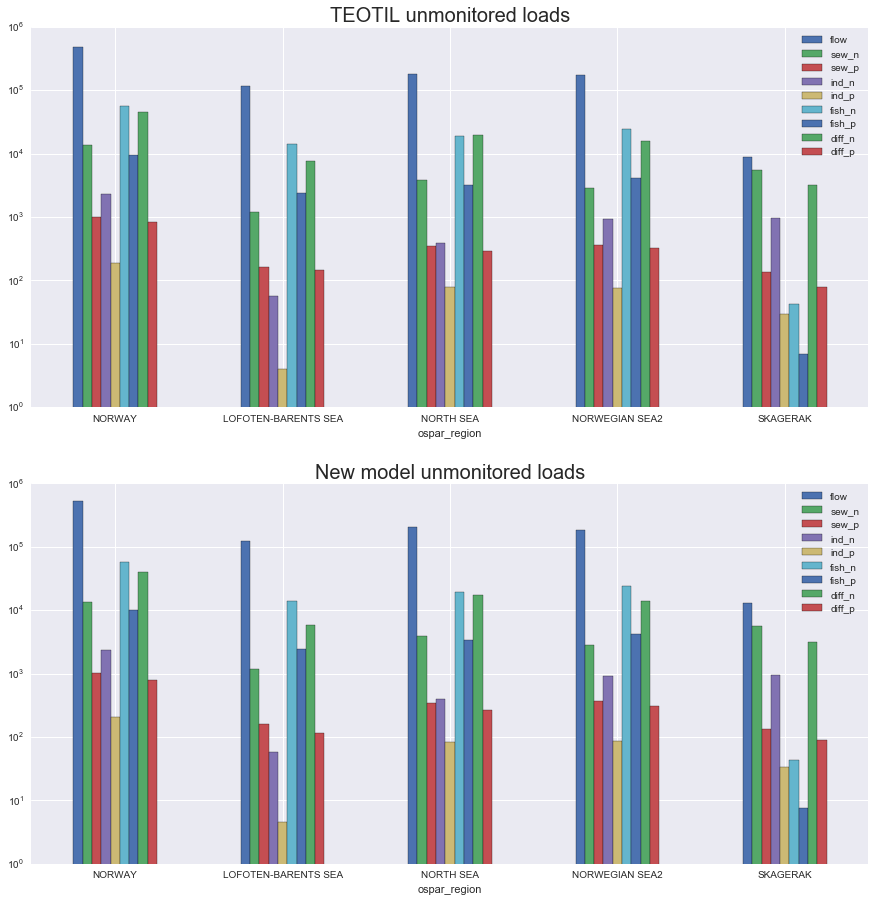

In [9]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,15))
old_df.plot.bar(ax=axes[0], rot=0, logy=True)
new_df.plot.bar(ax=axes[1], rot=0, logy=True)

# Labels
axes[0].set_title('TEOTIL unmonitored loads', fontsize=20)
axes[1].set_title('New model unmonitored loads', fontsize=20)

plt.show()

## 2. Other N and P species

Tore's procedure `RESA2.FIXTEOTILPN` defines simple correction factors for estimating PO4, NO3 and NH4 from total P and N. The table below lists the factors used.

|             | Phosphate | Nitrate | Ammonium |
|:-----------:|:---------:|:-------:|:--------:|
|    Sewage   |     0.600 |   0.050 |    0.750 |
|   Industry  |     0.600 |   0.050 |    0.750 |
| Aquaculture |     0.690 |   0.110 |    0.800 |
|   Diffuse   |     0.246 |   0.625 |    0.055 |

In [10]:
# Dict of conversion factors
con_dict = {('sew', 'po4'):('p', 0.6),
            ('ind', 'po4'):('p', 0.6),
            ('fish', 'po4'):('p', 0.69),
            ('diff', 'po4'):('p', 0.246),
            ('sew', 'no3'):('n', 0.05),
            ('ind', 'no3'):('n', 0.05),
            ('fish', 'no3'):('n', 0.11),
            ('diff', 'no3'):('n', 0.625),
            ('sew', 'nh4'):('n', 0.75),
            ('ind', 'nh4'):('n', 0.75),
            ('fish', 'nh4'):('n', 0.8),
            ('diff', 'nh4'):('n', 0.055)}

# Apply factors
for src in ['sew', 'ind', 'fish', 'diff']:
    for spc in ['po4', 'no3', 'nh4']:
        el, fac = con_dict[(src, spc)]
        new_df[src+'_'+spc] = fac * new_df[src+'_'+el]
        
new_df.round().astype(int).T

ospar_region,NORWAY,LOFOTEN-BARENTS SEA,NORTH SEA,NORWEGIAN SEA2,SKAGERAK
flow,521983,125082,202846,181224,12830
sew_n,13456,1201,3876,2778,5601
sew_p,1006,163,346,365,133
ind_n,2342,58,400,930,954
ind_p,208,4,83,87,34
fish_n,57569,14083,19268,24174,43
fish_p,9948,2433,3324,4184,8
diff_n,40577,5830,17552,14074,3121
diff_p,779,115,271,305,89
sew_po4,604,98,207,219,80


## 3. Other quantities

The model currently only considers N and P, but the project focuses on a wider range of parameters. For now, we simply assume that all measured inputs (`renseanlegg`, `industri` and `akvakultur`) for regines outside of catchments with measured data make it to the sea.

In [11]:
# Connect to db
resa2_basic_path = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\Upload_Template'
                    r'\useful_resa2_code.py')

resa2_basic = imp.load_source('useful_resa2_code', resa2_basic_path)

engine, conn = resa2_basic.connect_to_resa2()

We only want data for catchments that are not monitored i.e. for regine IDs **not** in the graph created above.

In [13]:
year = 2015

# The sql below uses a horrible (and slow!) hack to get around Oracle's
# 1000 item limit on IN clauses. See here for details:
# https://stackoverflow.com/a/9084247/505698
nd_list_hack = [(1, i) for i in nd_list]

sql = ("SELECT SUBSTR(a.regine, 1, 3) AS vassdrag, "
       "  a.type, "
       "  b.name, "
       "  b.unit, "
       "  SUM(c.value * d.factor) as value "
       "FROM RESA2.RID_PUNKTKILDER a, "
       "RESA2.RID_PUNKTKILDER_OUTPAR_DEF b, "
       "RESA2.RID_PUNKTKILDER_INPAR_VALUES c, "
       "RESA2.RID_PUNKTKILDER_INP_OUTP d "
       "WHERE a.anlegg_nr = c.anlegg_nr "
       "AND (1, a.regine) NOT IN %s "
       "AND d.in_pid = c.inp_par_id "
       "AND d.out_pid = b.out_pid "
       "AND c.year = %s "
       "GROUP BY SUBSTR(a.regine, 1, 3), a.type, b.name, b.unit "
       "ORDER BY SUBSTR(a.regine, 1, 3), a.type" % (tuple(nd_list_hack), year))

df = pd.read_sql(sql, engine)

# Tidy
df['par'] = df['type'] + '_' + df['name'] + '_' + df['unit']
del df['name'], df['unit'], df['type']

# Pivot
df = df.pivot(index='vassdrag', columns='par', values='value')
df.reset_index(inplace=True)

In [14]:
def f(x):
    try:
        a = int(x)
        return a
    except:
        return -999

# Convert vassdrag to numbers
df['vass'] = df['vassdrag'].apply(f)

# Get just the main catchments
df = df.query('vass != -999')

df.head()

par,vassdrag,INDUSTRI_As_tonn,INDUSTRI_Cd_tonn,INDUSTRI_Cr_tonn,INDUSTRI_Cu_tonn,INDUSTRI_Hg_tonn,INDUSTRI_NH3_tonn,INDUSTRI_NH4-N_tonn,INDUSTRI_Ni_tonn,INDUSTRI_PAH_tonn,...,RENSEANLEGG_Hg_tonn,RENSEANLEGG_Ni_tonn,RENSEANLEGG_PAH_tonn,RENSEANLEGG_PCB_tonn,RENSEANLEGG_Pb_tonn,RENSEANLEGG_S.P.M._tonn,RENSEANLEGG_Tot-N_tonn,RENSEANLEGG_Tot-P_tonn,RENSEANLEGG_Zn_tonn,vass
0,001,0.0597,0.0052,0.0105,0.0470,NaN,NaN,NaN,0.0494,NaN,...,0.000048,0.02807,0.000600,0.000000,0.00494,NaN,110.98735,5.13800,0.14505,1
1,002,0.0133,0.0055,0.6729,3.3083,0.012,NaN,NaN,0.4234,0.0002,...,0.000147,0.01815,0.000085,0.000051,0.00448,0.025,687.16123,17.36042,0.18853,2
2,003,NaN,NaN,NaN,0.0004,NaN,NaN,NaN,0.0002,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,282.00000,2.81000,NaN,3
3,004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,142.99000,1.69000,NaN,4
4,005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,32.72333,1.33740,NaN,5


In [15]:
def f2(x):   
    if x in range(1, 24):
        return 'SKAGERAK'
    elif x in range(24, 91):
        return 'NORTH SEA'
    elif x in range(91, 171):
        return 'NORWEGIAN SEA2'
    elif x in range(171, 248):
        return 'LOFOTEN-BARENTS SEA'
    else:
        return np.nan

# Assign main catchments to OSPAR regions
df['osp_reg'] = df['vass'].apply(f2)

df.head()

par,vassdrag,INDUSTRI_As_tonn,INDUSTRI_Cd_tonn,INDUSTRI_Cr_tonn,INDUSTRI_Cu_tonn,INDUSTRI_Hg_tonn,INDUSTRI_NH3_tonn,INDUSTRI_NH4-N_tonn,INDUSTRI_Ni_tonn,INDUSTRI_PAH_tonn,...,RENSEANLEGG_Ni_tonn,RENSEANLEGG_PAH_tonn,RENSEANLEGG_PCB_tonn,RENSEANLEGG_Pb_tonn,RENSEANLEGG_S.P.M._tonn,RENSEANLEGG_Tot-N_tonn,RENSEANLEGG_Tot-P_tonn,RENSEANLEGG_Zn_tonn,vass,osp_reg
0,001,0.0597,0.0052,0.0105,0.0470,NaN,NaN,NaN,0.0494,NaN,...,0.02807,0.000600,0.000000,0.00494,NaN,110.98735,5.13800,0.14505,1,SKAGERAK
1,002,0.0133,0.0055,0.6729,3.3083,0.012,NaN,NaN,0.4234,0.0002,...,0.01815,0.000085,0.000051,0.00448,0.025,687.16123,17.36042,0.18853,2,SKAGERAK
2,003,NaN,NaN,NaN,0.0004,NaN,NaN,NaN,0.0002,NaN,...,NaN,NaN,NaN,NaN,NaN,282.00000,2.81000,NaN,3,SKAGERAK
3,004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,142.99000,1.69000,NaN,4,SKAGERAK
4,005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,32.72333,1.33740,NaN,5,SKAGERAK


In [16]:
# Group by OSPAR region
df.fillna(0, inplace=True)
df = df.groupby('osp_reg').sum()
df.drop(0, inplace=True)

# Total for Norway
df.loc['NORWAY'] = df.sum(axis=0)

# Join to model results 
df = new_df.join(df)

# Get cols of interest
umod_cols = ['S.P.M.', 'TOC', 'As', 'Pb', 'Cd', 'Cu', 'Zn', 'Ni', 'Cr', 'Hg']
umod_cols = ['%s_%s_tonn' % (i, j) for i in ['INDUSTRI', 'RENSEANLEGG'] for j in umod_cols]
cols = list(new_df.columns) + umod_cols
cols.remove('RENSEANLEGG_TOC_tonn')
df = df[cols]

df.round(0).astype(int).T

ospar_region,NORWAY,LOFOTEN-BARENTS SEA,NORTH SEA,NORWEGIAN SEA2,SKAGERAK
flow,521983,125082,202846,181224,12830
sew_n,13456,1201,3876,2778,5601
sew_p,1006,163,346,365,133
ind_n,2342,58,400,930,954
ind_p,208,4,83,87,34
fish_n,57569,14083,19268,24174,43
fish_p,9948,2433,3324,4184,8
diff_n,40577,5830,17552,14074,3121
diff_p,779,115,271,305,89
sew_po4,604,98,207,219,80


## 4. Fish farm copper

Finally, we need to add in the Cu totals from fish farms. The method is similar to that used above, but simpler because we're only interested in one parameter.

In [17]:
year = 2015

# The sql below uses a horrible (and slow!) hack to get around Oracle's
# 1000 item limit on IN clauses. See here for details:
# https://stackoverflow.com/a/9084247/505698
nd_list_hack = [(1, i) for i in nd_list]

sql = ("SELECT SUBSTR(a.regine, 1, 3) AS vassdrag, "
       "  SUM(b.value) as value "
       "FROM RESA2.RID_KILDER_AQUAKULTUR a, "
       "RESA2.RID_KILDER_AQKULT_VALUES b "
       "WHERE a.nr = b.anlegg_nr "
       "AND (1, a.regine) NOT IN %s "
       "AND b.inp_par_id = 41 "
       "AND b.ar = %s "
       "GROUP BY SUBSTR(a.regine, 1, 3), b.inp_par_id "
       "ORDER BY SUBSTR(a.regine, 1, 3), b.inp_par_id" % (tuple(nd_list_hack), year))

aq_df = pd.read_sql(sql, engine)

# Get vassdrag
aq_df['vass'] = aq_df['vassdrag'].apply(f)
aq_df = aq_df.query('vass != -999')

# Calc OSPAR region and group
aq_df['osp_reg'] = aq_df['vass'].apply(f2)
aq_df.fillna(0, inplace=True)
aq_df = aq_df.groupby('osp_reg').sum()
del aq_df['vass']

# Total for Norway
aq_df.loc['NORWAY'] = aq_df.sum(axis=0)

# Rename
aq_df.columns = ['AQUAKULTUR_Cu_tonn',]

# Join model results 
df = df.join(aq_df)

df.round(0).astype(int).T

ospar_region,NORWAY,LOFOTEN-BARENTS SEA,NORTH SEA,NORWEGIAN SEA2,SKAGERAK
flow,521983,125082,202846,181224,12830
sew_n,13456,1201,3876,2778,5601
sew_p,1006,163,346,365,133
ind_n,2342,58,400,930,954
ind_p,208,4,83,87,34
fish_n,57569,14083,19268,24174,43
fish_p,9948,2433,3324,4184,8
diff_n,40577,5830,17552,14074,3121
diff_p,779,115,271,305,89
sew_po4,604,98,207,219,80


In [18]:
# Write output
out_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\Results\Unmon_loads\unmon_loads_2015.csv')
df.to_csv(out_csv)

This data can then be used to create Table 3 in the report - see [this notebook](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/word_data_tables.ipynb) for details.